**Importing necessary libraries**

In [592]:
#importing all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from statsmodels.sandbox.regression.predstd import wls_prediction_std

suppressing warnings

In [593]:
import warnings
warnings.filterwarnings('ignore')

**Importing data and checking head**

In [594]:
#importing biking data from upgrad
url = 'https://cdn.upgrad.com/uploads/production/b7624eea-49ad-40e3-8bb6-6f6c0164d14b/day.csv'
rental = pd.read_csv(url)
rental.head() #checking 1st 5 rows of imported data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**Describing columns for their overview**

In [595]:
rental.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


**Checking data types of columns**

In [596]:
rental.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

#Feature level insights:
*   **Categorical columns:** season, mnth, weekday, weathersit
*   **Binary columns:** yr, workingday, holiday
*   **Continuous columns:** temp, atemp, hum, windspeed, cnt, casual, registered
*   **Redundant**: instant (serial number column) and dteday(masked date)

In [597]:
print(rental[['season','weekday','weathersit','mnth']].astype(object).describe())

        season  weekday  weathersit  mnth
count      730      730         730   730
unique       4        7           3    12
top          3        6           1    12
freq       188      105         463    62


**Creating a copy of base data to do transformations/cleaning**

In [598]:
rental_data = rental.copy()



*   **Dropping columns which are redundant: instant, dteday**
*   **Dropping columns which are components of target variable: casual, registered**




In [599]:
rental_data = rental_data.drop(['instant','dteday','casual','registered'],axis=1)
rental_data.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600
5,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,1606
6,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,1510
7,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,959
8,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,822
9,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,1321


**Performaing a basic correlation analysis on raw dataset to identify any major issues/insights**

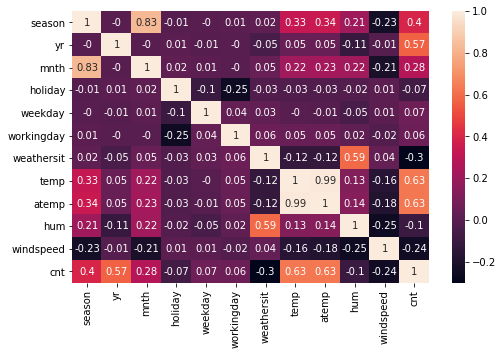

In [600]:
#creating correlation matrix
correlation_matrix = rental_data.corr().round(2)

#overlaying heatmap on top of correlation matrix

# annot = True to print the values inside the square
fig, ax = plt.subplots(figsize=(8,5))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, ax=ax)

**Target variable:** cnt

#Insights:

**Correlations between depedent and independent variables:**
*   Variables high correlation with target variable: season, yr, temp,atemp.
*   Variables moderate correlation with target variable: mnth, weathersit, windspeed. 
*   Variables weak correlation with target variable: holiday, weekday, workingday, hum.


**Multicollinearity issues:**
*   Variable 'atemp' having 0.99 correlation with 'temp'
*   Variable 'hum' having 0.59 correlation with 'weathersit'


**Insight:** Variables with high multicollinearity makes a linear regression model unstable and should be removed. The above analysis just highlights potential issues with features, we would be further analysis VIFs, correlation to target variable and p-value before stepwise elimination of multicollinear variables.







**Training an arbitrary OLS model without any data prepration to:**



1.   Calculate p-value of independent variables [to aid in elimination of features which have high p-value, high VIF and high multicollinearity] 
2.   Guage impact of data preprations and feature selections on final model performance



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     195.9
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          8.06e-186
Time:                        17:42:45   Log-Likelihood:                -4797.8
No. Observations:                 584   AIC:                             9620.
Df Residuals:                     572   BIC:                             9672.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1214.5351    292.703      4.149      0.0

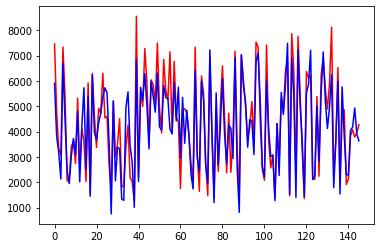

In [601]:
rental_xbase = rental_data.copy().drop(['cnt'],axis=1)
rental_ybase = rental_data.copy()['cnt']
X_train, X_test, y_train, y_test = train_test_split(rental_xbase, rental_ybase, test_size=0.20, random_state=42)

#Building a OLS model for p-value analysis
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

#linear regression model through sklearn
regression_model = LinearRegression()

#Fit the data(train the model)
regression_model.fit(X_train, y_train)

# Predict
y_predicted = regression_model.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

#plotting predicted vs actual value. y_test is in dataframe format, converting it into numpy array for plotting.
plt.plot(y_test.to_numpy(), color='r')
plt.plot(y_predicted, color='b')
plt.show()

**Estimating VIFs on base data just to see any alarming dependencies in the initial dataset itself**

In [602]:
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const          61.229197
season          3.892783
yr              1.024467
mnth            3.709790
holiday         1.095329
weekday         1.018861
workingday      1.090733
weathersit      1.763740
temp          165.904999
atemp         169.383307
hum             1.900547
windspeed       1.225141
dtype: float64


**Early feature elimination based on p-value, VIF, correlation matrix:**

Both 'temp' and 'atemp' have high multicollinearity and thus we would be deciding to eliminate one of them. 

Off these 2 variables, 'temp' has both high VIF and high p-value, thus eliminating it from model.

In [603]:
rental_data = rental_data.drop(['temp'],axis=1)

**Recalculating VIFs to see if the problem is solved**

In [604]:
rental_xbase = rental_data.copy()
rental_ybase = rental_data.copy()['cnt']
X_train, X_test, y_train, y_test = train_test_split(rental_xbase, rental_ybase, test_size=0.20, random_state=42)

#Building a OLS model for p-value analysis
X = X_train
y = y_train

vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const         53.814756
season         4.312397
yr             2.272425
mnth           3.744784
holiday        1.099962
weekday        1.041742
workingday     1.095781
weathersit     1.877588
atemp          2.384723
hum            1.888661
windspeed      1.200883
cnt            4.765748
dtype: float64


**Replacing levels in categorical variables with string value to covert columns into object data type. This will not only help in dummy encoding but will also give better interpretability to the dummy variables.**

In [605]:
#defining new object columns
rental_data['season_object'] = 'Null'
rental_data['weekday_object'] = 'Null'
rental_data['weathersit_object'] = 'Null'
rental_data['mnth_object'] = 'Null'

#setting values in new object columns
rental_data['season_object'].loc[rental_data['season'] == 1] = "spring"
rental_data['season_object'].loc[rental_data['season'] == 2] = "summer"
rental_data['season_object'].loc[rental_data['season'] == 3] = "fall"
rental_data['season_object'].loc[rental_data['season'] == 4] = "winter"

rental_data['weekday_object'].loc[rental_data['weekday'] == 0] = "sunday"
rental_data['weekday_object'].loc[rental_data['weekday'] == 1] = "monday"
rental_data['weekday_object'].loc[rental_data['weekday'] == 2] = "tuesday"
rental_data['weekday_object'].loc[rental_data['weekday'] == 3] = "wednesday"
rental_data['weekday_object'].loc[rental_data['weekday'] == 4] = "thursday"
rental_data['weekday_object'].loc[rental_data['weekday'] == 5] = "friday"
rental_data['weekday_object'].loc[rental_data['weekday'] == 6] = "saturday"

rental_data['weathersit_object'].loc[rental_data['weathersit'] == 1] = "clear"
rental_data['weathersit_object'].loc[rental_data['weathersit'] == 2] = "mist"
rental_data['weathersit_object'].loc[rental_data['weathersit'] == 3] = "snow"
rental_data['weathersit_object'].loc[rental_data['weathersit'] == 4] = "rain"


rental_data['mnth_object'].loc[rental_data['mnth'] == 1] = "jan"
rental_data['mnth_object'].loc[rental_data['mnth'] == 2] = "feb"
rental_data['mnth_object'].loc[rental_data['mnth'] == 3] = "mar"
rental_data['mnth_object'].loc[rental_data['mnth'] == 4] = "apr"
rental_data['mnth_object'].loc[rental_data['mnth'] == 5] = "may"
rental_data['mnth_object'].loc[rental_data['mnth'] == 6] = "jun"
rental_data['mnth_object'].loc[rental_data['mnth'] == 7] = "jul"
rental_data['mnth_object'].loc[rental_data['mnth'] == 8] = "aug"
rental_data['mnth_object'].loc[rental_data['mnth'] == 9] = "sep"
rental_data['mnth_object'].loc[rental_data['mnth'] == 10] = "oct"
rental_data['mnth_object'].loc[rental_data['mnth'] == 11] = "nov"
rental_data['mnth_object'].loc[rental_data['mnth'] == 12] = "dec"

#dropping columns for which an object columns is already created
rental_data = rental_data.drop(['season','mnth','weekday','weathersit'],axis=1)

rental_data = rental_data.sort_values(by='cnt' , ascending=False)

rental_data.head(20)

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_object,weekday_object,weathersit_object,mnth_object
622,1,0,0,29.29335,50.1667,16.583907,8714,fall,saturday,clear,sep
636,1,0,0,26.51480,54.2917,15.249468,8555,winter,saturday,clear,sep
629,1,0,0,30.52440,64.6667,19.000061,8395,fall,saturday,clear,sep
446,1,0,1,28.50335,69.4167,7.792100,8362,summer,friday,mist,mar
503,1,0,0,28.34540,45.6250,5.626325,8294,summer,saturday,clear,may
616,1,0,0,28.94625,54.7500,15.041232,8227,fall,sunday,clear,sep
570,1,0,1,32.70270,45.0000,11.041600,8173,fall,wednesday,clear,jul
628,1,0,1,28.59855,66.8750,10.333343,8167,fall,friday,clear,sep
642,1,0,1,29.00935,62.7500,7.125450,8156,winter,friday,clear,oct
517,1,0,0,28.31440,54.9167,12.499654,8120,summer,saturday,clear,jun


#**EDA analysis for data insights**

**No null values detected across columns**

In [606]:
rental_data.isnull().sum()

yr                   0
holiday              0
workingday           0
atemp                0
hum                  0
windspeed            0
cnt                  0
season_object        0
weekday_object       0
weathersit_object    0
mnth_object          0
dtype: int64

**Outlier assesment for continuous variables through box plot**

Varibales 'hum' and 'windspeed' has outliers

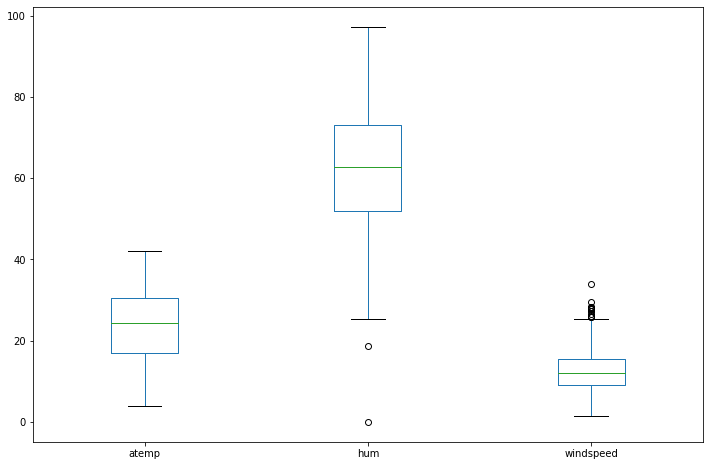

In [607]:
df_box_plot_data = rental_data[["atemp","hum","windspeed"]].copy()
df_box_plot_data.plot(kind='box', figsize=(12,8))
plt.show()

**Outlier treatment for 'hum' and 'windspeed' through clipping**

In [608]:
print("Dataframe shape before outlier elimination:" ,rental_data.shape)

rental_data = rental_data.loc[(rental_data['hum'] >= 30) & (rental_data['windspeed'] <= 30)]

print("Dataframe shape after outlier elimination:" ,rental_data.shape)

Dataframe shape before outlier elimination: (730, 11)
Dataframe shape after outlier elimination: (725, 11)


**Given the outlier elimination just reduces data size by only 0.7% (negligible), we finalized outlier elimination as a strategy to deal with outliers (versus imputation).**

**Re-plotting boxplot to verify Outlier elimination**

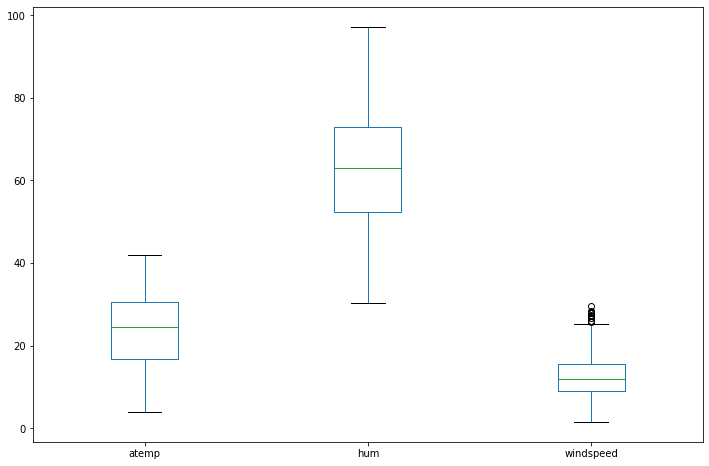

In [609]:
df_box_plot_data = rental_data[["atemp","hum","windspeed"]].copy()
df_box_plot_data.plot(kind='box', figsize=(12,8))
plt.show()

# EDA analysis between target variable and weather type:

**Insight: More bikes are rented in clear weather and least number of bikes are rented in snow (slippery roads).**

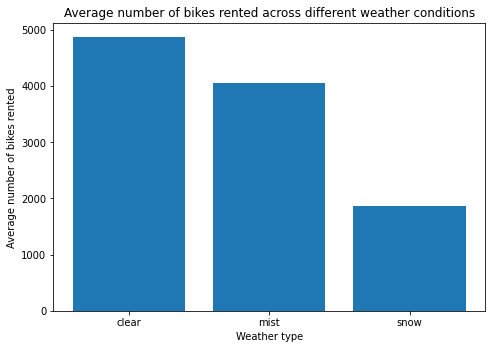

In [610]:
pivt = rental_data.pivot_table(index='weathersit_object',values='cnt',aggfunc = 'mean')
repaired_df = pd.DataFrame(pivt.to_records())
repaired_df.head()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(repaired_df['weathersit_object'],repaired_df['cnt'])
ax.set_ylabel('Average number of bikes rented')
ax.set_xlabel('Weather type')
ax.set_title('Average number of bikes rented across different weather conditions')
plt.show()

# EDA analysis between target variable and weekday:

**Insight: No strong trend, but generally more bikes are rented when weekend approaches versus least number of bikes being rented on Sunday and Monday.**

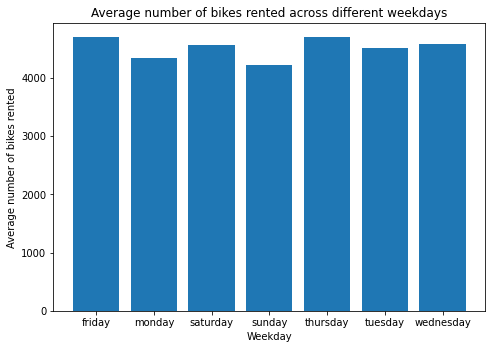

In [611]:
pivt = rental_data.pivot_table(index='weekday_object',values='cnt',aggfunc = 'mean')
repaired_df = pd.DataFrame(pivt.to_records())
repaired_df.head()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(repaired_df['weekday_object'],repaired_df['cnt'])
ax.set_ylabel('Average number of bikes rented')
ax.set_xlabel('Weekday')
ax.set_title('Average number of bikes rented across different weekdays')
plt.show()

# EDA analysis between target variable and season:

**Insight: Highest number of bikes are rented in fall versus least number of bikes being rented in spring. Average temperature is lowest in spring which contributes towards lower demand.**

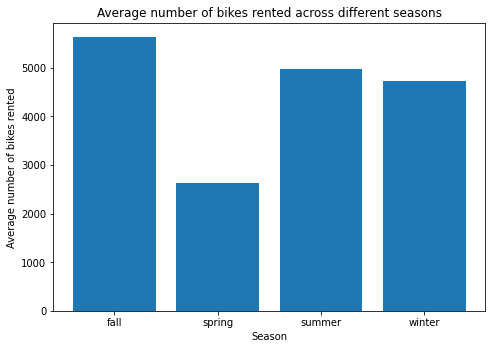

In [612]:
pivt = rental_data.pivot_table(index='season_object',values='cnt',aggfunc = 'mean')
repaired_df = pd.DataFrame(pivt.to_records())
repaired_df.head()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(repaired_df['season_object'],repaired_df['cnt'])
ax.set_ylabel('Average number of bikes rented')
ax.set_xlabel('Season')
ax.set_title('Average number of bikes rented across different seasons')
plt.show()

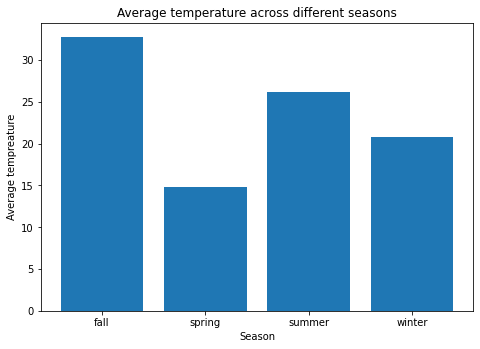

In [613]:
pivt = rental_data.pivot_table(index='season_object',values='atemp',aggfunc = 'mean')
repaired_df = pd.DataFrame(pivt.to_records())
repaired_df.head()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(repaired_df['season_object'],repaired_df['atemp'])
ax.set_ylabel('Average tempreature')
ax.set_xlabel('Season')
ax.set_title('Average temperature across different seasons')
plt.show()

# EDA analysis between target variable and temperature:

**Insight: Bike renting increases with increasing temperature**

[149.74154758 955.80943819]
 
149.7 x + 955.8


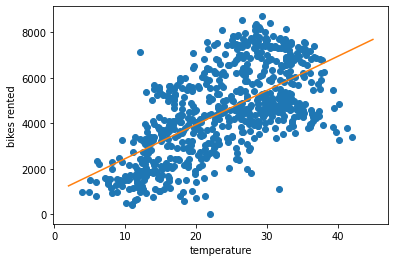

In [614]:
plot_clean = (rental_data.copy()).dropna()
x = plot_clean['atemp']
y = plot_clean['cnt']
#plt.plot(x,y)
x = x.to_numpy()
y = y.to_numpy()
#print(x)
#print(y)
z = np.polyfit(x, y,1)
print(z)
p = np.poly1d(z)
print(p)
t = np.linspace(2,45,num=45)

#plt.plot(x,p(x),"r--")
plt.plot(x, y,'o',t, p(t), '-')

plt.xlabel('temperature')
plt.ylabel('bikes rented')

plt.show()

# EDA analysis between target variable and humidity:

**Insight: Bike renting slightly decreases with increasing humidity**

[ -16.08074469 5526.39316489]
 
-16.08 x + 5526


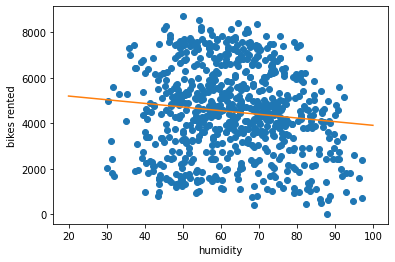

In [615]:
x = plot_clean['hum'].loc[plot_clean['hum']>20] #filtering data for removing outliers which can impact chart adversily
y = plot_clean['cnt'].loc[plot_clean['hum']>20] #filtering data for removing outliers which can impact chart adversily
#plt.plot(x,y)
x = x.to_numpy()
y = y.to_numpy()
#print(x)
#print(y)
z = np.polyfit(x, y,1)
print(z)
p = np.poly1d(z)
print(p)
t = np.linspace(20,100,num=80)

#plt.plot(x,p(x),"r--")
plt.plot(x, y,'o',t, p(t), '-')

plt.xlabel('humidity')
plt.ylabel('bikes rented')

plt.show()

# EDA analysis between target variable and windspeed:

**Insight: Bike renting slightly decreases with increasing windspeed**

[ -86.59105069 5613.47942819]
 
-86.59 x + 5613


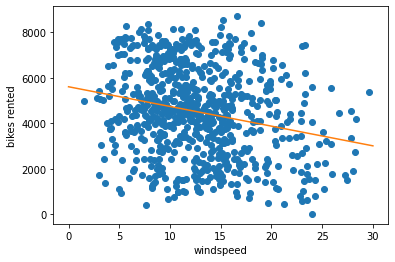

In [616]:
x = plot_clean['windspeed'].loc[plot_clean['windspeed']<=30] #filtering data for removing outliers which can impact chart adversily
y = plot_clean['cnt'].loc[plot_clean['windspeed']<=30] #filtering data for removing outliers which can impact chart adversily
#plt.plot(x,y)
x = x.to_numpy()
y = y.to_numpy()
#print(x)
#print(y)
z = np.polyfit(x, y,1)
print(z)
p = np.poly1d(z)
print(p)
t = np.linspace(0,30,num=30)

#plt.plot(x,p(x),"r--")
plt.plot(x, y,'o',t, p(t), '-')

plt.xlabel('windspeed')
plt.ylabel('bikes rented')

plt.show()

**Checking data types for all the columns before dummy encoding.**
All the categorical columns are now having object data type. Thus we are good to go with dummy encoding.

In [617]:
print(rental_data.dtypes)
print(rental_data[['season_object','weekday_object','weathersit_object','mnth_object']].astype(object).describe())

yr                     int64
holiday                int64
workingday             int64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
season_object         object
weekday_object        object
weathersit_object     object
mnth_object           object
dtype: object
       season_object weekday_object weathersit_object mnth_object
count            725            725               725         725
unique             4              7                 3          12
top             fall         monday             clear         jan
freq             188            105               459          62


**Dummy encoding categorical columns**

drop_first is set to 'True' to drop 1st dummy column for every variable which is dummy encoded.

In [618]:
rental_data_with_dummies = pd.get_dummies(rental_data,drop_first=True)
rental_data_with_dummies.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_object_spring,season_object_summer,season_object_winter,weekday_object_monday,weekday_object_saturday,weekday_object_sunday,weekday_object_thursday,weekday_object_tuesday,weekday_object_wednesday,weathersit_object_mist,weathersit_object_snow,mnth_object_aug,mnth_object_dec,mnth_object_feb,mnth_object_jan,mnth_object_jul,mnth_object_jun,mnth_object_mar,mnth_object_may,mnth_object_nov,mnth_object_oct,mnth_object_sep
622,1,0,0,29.29335,50.1667,16.583907,8714,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
636,1,0,0,26.51480,54.2917,15.249468,8555,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
629,1,0,0,30.52440,64.6667,19.000061,8395,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
446,1,0,1,28.50335,69.4167,7.792100,8362,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
503,1,0,0,28.34540,45.6250,5.626325,8294,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


**Insights from below correlation matrix:** Possible multicollinearity issue between variables with greater than 0.5 correlation with each other (excluding target variable 'cnt'). 

Examples of this issue:
*   'working_day' with 'weekday_object_sunday' and 'weekday_object_saturday'.
*   'season_object_spring' with 'atemp'.
*   'season_object_winter' with 'mnth_object_nov' and 'mnth_object_dec'

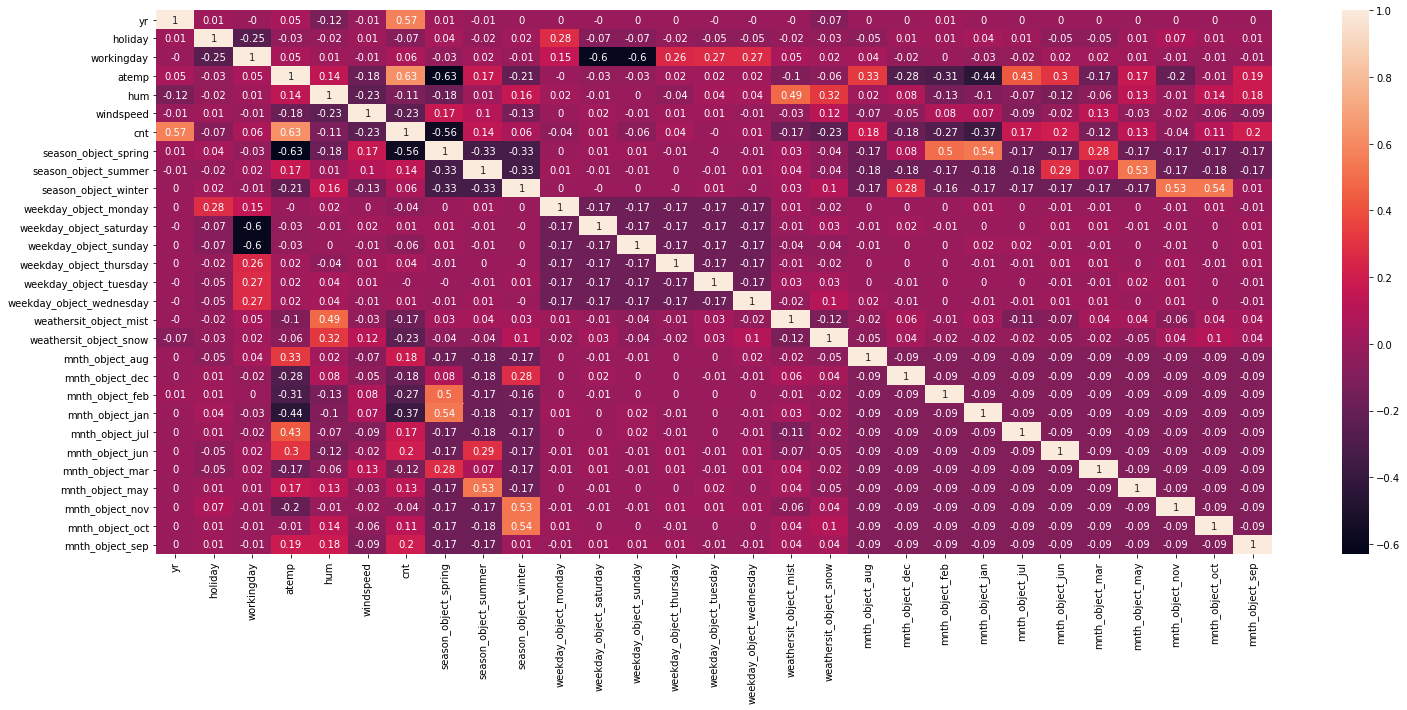

In [619]:
correlation_matrix = rental_data_with_dummies.corr().round(2)

#overlaying heatmap on top of correlation matrix
# annot = True to print the values inside the square
fig, ax = plt.subplots(figsize=(25,10))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, ax=ax)

**Splitting data between train and test sets**

In [620]:
rental_xbase = rental_data_with_dummies.copy().drop(['cnt'],axis=1)
rental_ybase = rental_data_with_dummies.copy()['cnt']
X_train, X_test, y_train, y_test = train_test_split(rental_xbase, rental_ybase, test_size=0.20, random_state=42)

**Scaling continuous independent variables in training data**

In [621]:
scaler = MinMaxScaler()
num_vars = ['atemp','hum','windspeed']
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train[num_vars].head()

,atemp,hum,windspeed
310,0.422408,0.681125,0.083100
570,0.754745,0.220529,0.339738
224,0.743986,0.637614,0.451038
693,0.234323,0.247878,0.305623
311,0.437339,0.625804,0.111281


**Scaling continuous independent variables in testing data**

In [622]:
num_vars = ['atemp','hum','windspeed']
X_test[num_vars] = scaler.transform(X_test[num_vars])
X_test[num_vars].head()

,atemp,hum,windspeed
493,0.622130,0.659370,0.462866
321,0.254194,0.160856,0.348643
320,0.320482,0.408248,0.675071
569,0.823521,0.526350,0.451038
566,0.618044,0.840252,0.455442


**Building a OLS model for p-value analysis**

In [623]:
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     110.1
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.96e-202
Time:                        17:42:51   Log-Likelihood:                -4672.0
No. Observations:                 580   AIC:                             9400.
Df Residuals:                     552   BIC:                             9522.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

**Calculating VIFs for independent variables**

In [624]:
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                        0.000000
yr                           1.064031
holiday                           inf
workingday                        inf
atemp                        6.559713
hum                          2.409486
windspeed                    1.240469
season_object_spring        10.901555
season_object_summer         8.154707
season_object_winter         8.551101
weekday_object_monday        1.818284
weekday_object_saturday           inf
weekday_object_sunday             inf
weekday_object_thursday      1.699503
weekday_object_tuesday       1.727311
weekday_object_wednesday     1.698571
weathersit_object_mist       1.756842
weathersit_object_snow       1.491357
mnth_object_aug              5.881807
mnth_object_dec              5.501921
mnth_object_feb              5.359510
mnth_object_jan              5.570747
mnth_object_jul              6.085631
mnth_object_jun              2.680083
mnth_object_mar              3.237582
mnth_object_may              1.972767
mnth_object_



*   **Variables with 'infinite' VIF:** holiday, workingday, weekday_object_saturday, weekday_object_sunday
*   **Variables with high (> 5) VIF:** atemp, season_object_spring , season_object_winter , season_object_summer , mnth_object_aug , mnth_object_dec, mnth_object_jan , mnth_object_jul , mnth_object_nov, mnth_object_oct

#Note: We would be eliminating variables with p-values greater than 0.05 but for now I am targeting very high p-values of greater than 0.1

**Variables with very high (>0.1) p-value:** mnth_object_aug, season_object_summer , mnth_object_oct , mnth_object_mar , mnth_object_jun , weekday_object_wednesday , weekday_object_thursday , mnth_object_feb

**Removing 'season_object_summer' as it has both high VIF and High p-value.**

In [625]:
X_train = X_train.drop(['season_object_summer'],axis=1)

**Rebuilding OLS model to analyse p-values of remaining features**

In [626]:
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     114.4
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          2.13e-203
Time:                        17:42:52   Log-Likelihood:                -4672.2
No. Observations:                 580   AIC:                             9398.
Df Residuals:                     553   BIC:                             9516.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Rsq [old]: 0.843
Rsq [new]: 0.843

Rsq_adj [old]: 0.836
Rsq_adj [new]: 0.836

**Re-calculating VIFs for remaining independent features**

In [627]:
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                       0.000000
yr                          1.063865
holiday                          inf
workingday                       inf
atemp                       6.459134
hum                         2.403725
windspeed                   1.239613
season_object_spring        6.646178
season_object_winter        7.273043
weekday_object_monday       1.818112
weekday_object_saturday          inf
weekday_object_sunday            inf
weekday_object_thursday     1.696902
weekday_object_tuesday      1.726861
weekday_object_wednesday    1.698107
weathersit_object_mist      1.756733
weathersit_object_snow      1.489433
mnth_object_aug             2.681786
mnth_object_dec             4.576481
mnth_object_feb             4.980154
mnth_object_jan             5.160307
mnth_object_jul             3.135897
mnth_object_jun             2.496446
mnth_object_mar             3.092367
mnth_object_may             1.970745
mnth_object_nov             4.917583
mnth_object_oct             5.135410
m

**Removing 'mnth_object_oct' as it has both high VIF and High p-value.**

In [628]:
X_train = X_train.drop(['mnth_object_oct'],axis=1)

**Rebuilding OLS model to analyse p-values of remaining features**

In [629]:
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     119.2
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.93e-204
Time:                        17:42:52   Log-Likelihood:                -4672.2
No. Observations:                 580   AIC:                             9396.
Df Residuals:                     554   BIC:                             9510.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Rsq [old]: 0.843
Rsq [new]: 0.843

Rsq_adj [old]: 0.836
Rsq_adj [new]: 0.836

**Re-calculating VIFs for remaining independent features**

In [630]:
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                       0.000000
yr                          1.063174
holiday                          inf
workingday                       inf
atemp                       6.458852
hum                         2.395964
windspeed                   1.238590
season_object_spring        5.464861
season_object_winter        2.798746
weekday_object_monday       1.818045
weekday_object_saturday          inf
weekday_object_sunday            inf
weekday_object_thursday     1.696117
weekday_object_tuesday      1.726312
weekday_object_wednesday    1.698082
weathersit_object_mist      1.755667
weathersit_object_snow      1.485904
mnth_object_aug             2.486141
mnth_object_dec             2.127965
mnth_object_feb             3.697190
mnth_object_jan             3.922044
mnth_object_jul             2.953107
mnth_object_jun             2.322916
mnth_object_mar             2.323863
mnth_object_may             1.801843
mnth_object_nov             1.771458
mnth_object_sep             1.667637
d

**Given there are no more variables with high p-value and high VIF, dropping the ones with high p-value**

**Removing 'mnth_object_aug' as it has High p-value. Rebuilding OLS model and calculating summary stats**

Rsq [old]: 0.843
Rsq [new]: 0.843

Rsq_adj [old]: 0.836
Rsq_adj [new]: 0.836

In [631]:
X_train = X_train.drop(['mnth_object_aug'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     124.2
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          2.46e-205
Time:                        17:42:52   Log-Likelihood:                -4672.5
No. Observations:                 580   AIC:                             9395.
Df Residuals:                     555   BIC:                             9504.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

**Removing 'weekday_object_wednesday' as it has High p-value. Rebuilding OLS model and calculating summary stats**

**Rsq:**
*   base: 0.843
*   last iteration: 0.843
*   new: 0.843


**Rsq_adj:**
*   old: 0.836
*   last iteration: 0.836
*   new: 0.837


In [632]:
X_train = X_train.drop(['weekday_object_wednesday'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     129.8
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          2.32e-206
Time:                        17:42:52   Log-Likelihood:                -4672.6
No. Observations:                 580   AIC:                             9393.
Df Residuals:                     556   BIC:                             9498.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'weekday_object_thursday' as it has High p-value. Rebuilding OLS model and calculating summary stats**

**Rsq:**
*   base: 0.843
*   last iteration: 0.843
*   new: 0.843


**Rsq_adj:**
*   old: 0.836
*   last iteration: 0.837
*   new: 0.837

In [633]:
X_train = X_train.drop(['weekday_object_thursday'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     135.9
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          2.06e-207
Time:                        17:42:52   Log-Likelihood:                -4672.7
No. Observations:                 580   AIC:                             9391.
Df Residuals:                     557   BIC:                             9492.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'mnth_object_jun' as it has High p-value. Rebuilding OLS model and calculating summary stats**

**Rsq:**
*   base: 0.843
*   last iteration: 0.843
*   new: 0.843


**Rsq_adj:**
*   old: 0.836
*   last iteration: 0.837
*   new: 0.837

In [634]:
X_train = X_train.drop(['mnth_object_jun'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     142.6
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.73e-208
Time:                        17:42:52   Log-Likelihood:                -4672.7
No. Observations:                 580   AIC:                             9389.
Df Residuals:                     558   BIC:                             9485.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'mnth_object_mar' as it has High p-value. Rebuilding OLS model and calculating summary stats**

**Rsq:**
*   base: 0.843
*   last iteration: 0.843
*   new: 0.843


**Rsq_adj:**
*   old: 0.836
*   last iteration: 0.837
*   new: 0.837

In [635]:
X_train = X_train.drop(['mnth_object_mar'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     149.8
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.87e-209
Time:                        17:42:52   Log-Likelihood:                -4673.0
No. Observations:                 580   AIC:                             9388.
Df Residuals:                     559   BIC:                             9480.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'weekday_object_tuesday' as it has High p-value. Rebuilding OLS model and calculating summary stats**

**Rsq:**
*   base: 0.843
*   last iteration: 0.843
*   new: 0.842


**Rsq_adj:**
*   old: 0.836
*   last iteration: 0.837
*   new: 0.837

In [636]:
X_train = X_train.drop(['weekday_object_tuesday'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     157.5
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          3.22e-210
Time:                        17:42:52   Log-Likelihood:                -4673.8
No. Observations:                 580   AIC:                             9388.
Df Residuals:                     560   BIC:                             9475.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'weekday_object_monday' as it has High p-value. Rebuilding OLS model and calculating summary stats**

**Rsq:**
*   base: 0.843
*   last iteration: 0.842
*   new: 0.841


**Rsq_adj:**
*   old: 0.836
*   last iteration: 0.837
*   new: 0.836

In [637]:
X_train = X_train.drop(['weekday_object_monday'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     165.4
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.23e-210
Time:                        17:42:52   Log-Likelihood:                -4675.5
No. Observations:                 580   AIC:                             9389.
Df Residuals:                     561   BIC:                             9472.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Calculating VIFs for remaining variables**

In [638]:
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                      0.000000
yr                         1.046280
holiday                         inf
workingday                      inf
atemp                      3.766972
hum                        2.266670
windspeed                  1.211264
season_object_spring       3.997194
season_object_winter       2.295321
weekday_object_saturday         inf
weekday_object_sunday           inf
weathersit_object_mist     1.728796
weathersit_object_snow     1.464393
mnth_object_dec            1.595003
mnth_object_feb            2.115772
mnth_object_jan            2.212236
mnth_object_jul            1.435003
mnth_object_may            1.193426
mnth_object_nov            1.664942
mnth_object_sep            1.164144
dtype: float64


**Removing 'holiday' as it has High VIF, lowest coefficient and highest p-value amoung all the variables with 'inf' VIF. Recalculating VIFs for remaining variables**

In [639]:
X_train = X_train.drop(['holiday'],axis=1)
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                      85.566178
yr                          1.046280
workingday                  7.635589
atemp                       3.766972
hum                         2.266670
windspeed                   1.211264
season_object_spring        3.997194
season_object_winter        2.295321
weekday_object_saturday     5.057427
weekday_object_sunday       5.038649
weathersit_object_mist      1.728796
weathersit_object_snow      1.464393
mnth_object_dec             1.595003
mnth_object_feb             2.115772
mnth_object_jan             2.212236
mnth_object_jul             1.435003
mnth_object_may             1.193426
mnth_object_nov             1.664942
mnth_object_sep             1.164144
dtype: float64


**Rebuilding OLS model and calculating summary stats**

No drop in R-sq or Adj. R-sq. noticed

In [640]:
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     165.4
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          1.23e-210
Time:                        17:42:52   Log-Likelihood:                -4675.5
No. Observations:                 580   AIC:                             9389.
Df Residuals:                     561   BIC:                             9472.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'weekday_object_sunday' as it has High VIF and high p-value.**

**Insight: No VIF is greater than 5 anymore (constant term excluded).**

In [641]:
X_train = X_train.drop(['weekday_object_sunday'],axis=1)
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                      54.347432
yr                          1.045109
workingday                  1.600911
atemp                       3.761794
hum                         2.266285
windspeed                   1.209744
season_object_spring        3.995653
season_object_winter        2.294389
weekday_object_saturday     1.576740
weathersit_object_mist      1.728636
weathersit_object_snow      1.464383
mnth_object_dec             1.590489
mnth_object_feb             2.114671
mnth_object_jan             2.207354
mnth_object_jul             1.434646
mnth_object_may             1.191214
mnth_object_nov             1.652830
mnth_object_sep             1.161264
dtype: float64


**Note:**
*   **R-sq and Adj. R-Sq. didn't deteriorate** post elimination of all variables based on p-value and VIF.
*   **Prob (F-statistic) is 5.7e-211 is much less than 0.05, thus model fit is significant.**
*   **p-value for all the variables is less than 0.05**

In [642]:
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     174.1
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          5.70e-211
Time:                        17:42:53   Log-Likelihood:                -4677.4
No. Observations:                 580   AIC:                             9391.
Df Residuals:                     562   BIC:                             9469.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

**Removing 'mnth_object_may' as it has high p-value.**

#Points to note:
*   **No major deterioration in R-sq and Adj. R-Sq.**  elimination of all variables based on p-value and VIF.
*   **Prob (F-statistic) is 2.42e-211 is much less than 0.05, thus model fit is significant.**
*   **p-value for all the variables is less than 0.05**

In [643]:
X_train = X_train.drop(['mnth_object_may'],axis=1)
X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     183.9
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          2.42e-211
Time:                        17:42:53   Log-Likelihood:                -4679.2
No. Observations:                 580   AIC:                             9392.
Df Residuals:                     563   BIC:                             9467.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [644]:
vif_estimation_data_frame = add_constant(X_train)
vif = pd.Series([variance_inflation_factor(vif_estimation_data_frame.values, i) 
               for i in range(vif_estimation_data_frame.shape[1])], 
              index=vif_estimation_data_frame.columns)
print(vif)

const                      53.938312
yr                          1.045094
workingday                  1.599745
atemp                       3.758710
hum                         2.216572
windspeed                   1.208630
season_object_spring        3.880060
season_object_winter        2.179702
weekday_object_saturday     1.576520
weathersit_object_mist      1.723145
weathersit_object_snow      1.452341
mnth_object_dec             1.588644
mnth_object_feb             2.114577
mnth_object_jan             2.206895
mnth_object_jul             1.390524
mnth_object_nov             1.652450
mnth_object_sep             1.122537
dtype: float64


**Extracting columns from final 'X_train' variable after feature selection through p-value and VIFs**

In [645]:
X_train.columns

Index(['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_object_spring',
       'season_object_winter', 'weekday_object_saturday',
       'weathersit_object_mist', 'weathersit_object_snow', 'mnth_object_dec',
       'mnth_object_feb', 'mnth_object_jan', 'mnth_object_jul',
       'mnth_object_nov', 'mnth_object_sep'],
      dtype='object')

**Setting 'X_test' to have the same variables as modified 'X_train'**

#Note: Scaling on 'X_test' was done along with scaling on 'X_train', so not doing that transformation again

In [646]:
X_test = X_test[['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_object_spring',
       'season_object_winter', 'weekday_object_saturday',
       'weathersit_object_mist', 'weathersit_object_snow', 'mnth_object_dec',
       'mnth_object_feb', 'mnth_object_jan', 'mnth_object_jul', 'mnth_object_nov', 'mnth_object_sep']]
X_test.head()

,yr,workingday,atemp,hum,windspeed,season_object_spring,season_object_winter,weekday_object_saturday,weathersit_object_mist,weathersit_object_snow,mnth_object_dec,mnth_object_feb,mnth_object_jan,mnth_object_jul,mnth_object_nov,mnth_object_sep
493,1,1,0.622130,0.659370,0.462866,0,0,0,1,0,0,0,0,0,0,0
321,0,1,0.254194,0.160856,0.348643,0,1,0,0,0,0,0,0,0,1,0
320,0,1,0.320482,0.408248,0.675071,0,1,0,1,0,0,0,0,0,1,0
569,1,1,0.823521,0.526350,0.451038,0,0,0,0,0,0,0,0,1,0,0
566,1,0,0.618044,0.840252,0.455442,0,0,1,0,1,0,0,0,1,0,0


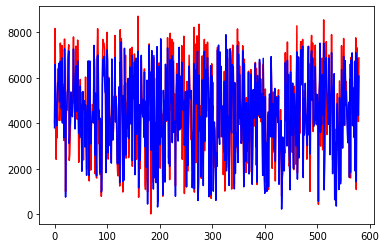

In [647]:
#calculating predicted values of y_train
y_train_pred = est2.predict(X2)

#plotting predicted vs actual value of y_train.
plt.plot(y_train.to_numpy(), color='r')
plt.plot(y_train_pred.to_numpy(), color='b')
plt.show()

#**Distribution of residuals is centered around 0 and is qualitatively normal distribution on predictions made on training data**

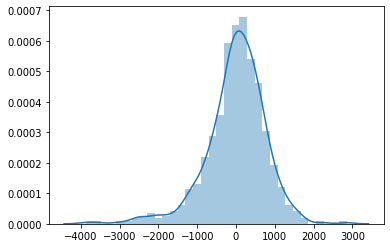

In [648]:
#plotting residuals
residuals = y_train - y_train_pred
sns.distplot(residuals)

**Residual distribution is having a random distribution, thus validating assumptions of random error & heteroscedasticity**

[-9.65588011e-16 -6.52902248e-12]
 
-9.656e-16 x - 6.529e-12


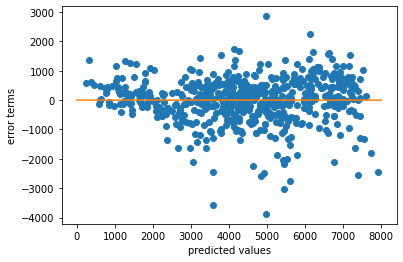

In [649]:
#plt.plot(x,y)
x = y_train_pred.to_numpy()
y = residuals.to_numpy()
#print(x)
#print(y)
z = np.polyfit(x, y,1)
print(z)
p = np.poly1d(z)
print(p)
t = np.linspace(0,8000,num=8000)

#plt.plot(x,p(x),"r--")
plt.plot(x, y,'o',t, p(t), '-')

plt.xlabel('predicted values')
plt.ylabel('error terms')

plt.show()

In [650]:
X_train.head()

,yr,workingday,atemp,hum,windspeed,season_object_spring,season_object_winter,weekday_object_saturday,weathersit_object_mist,weathersit_object_snow,mnth_object_dec,mnth_object_feb,mnth_object_jan,mnth_object_jul,mnth_object_nov,mnth_object_sep
310,0,1,0.422408,0.681125,0.083100,0,1,0,0,0,0,0,0,0,1,0
570,1,1,0.754745,0.220529,0.339738,0,0,0,0,0,0,0,0,1,0,0
224,0,0,0.743986,0.637614,0.451038,0,0,1,1,0,0,0,0,0,0,0
693,1,0,0.234323,0.247878,0.305623,0,1,0,0,0,0,0,0,0,1,0
311,0,1,0.437339,0.625804,0.111281,0,1,0,0,0,0,0,0,0,1,0


**Extracting coefficient's magnitude (modulus)**

In [689]:

features = pd.DataFrame(est2.params)
features.reset_index(inplace=True)
(features.rename(columns={'index': 'variables', 0: 'Coeff'}, inplace=True))
features['Coeff'] = (features['Coeff']*features['Coeff'])**(1/2)
features = features.sort_values(by=['Coeff'] , ascending=False)
features.head()

,variables,Coeff
3,atemp,3875.735886
0,const,2595.746521
10,weathersit_object_snow,2016.292313
1,yr,1997.181125
5,windspeed,1141.937086


Text(0.5, 1.0, 'Feature importance')

<Figure size 432x288 with 0 Axes>

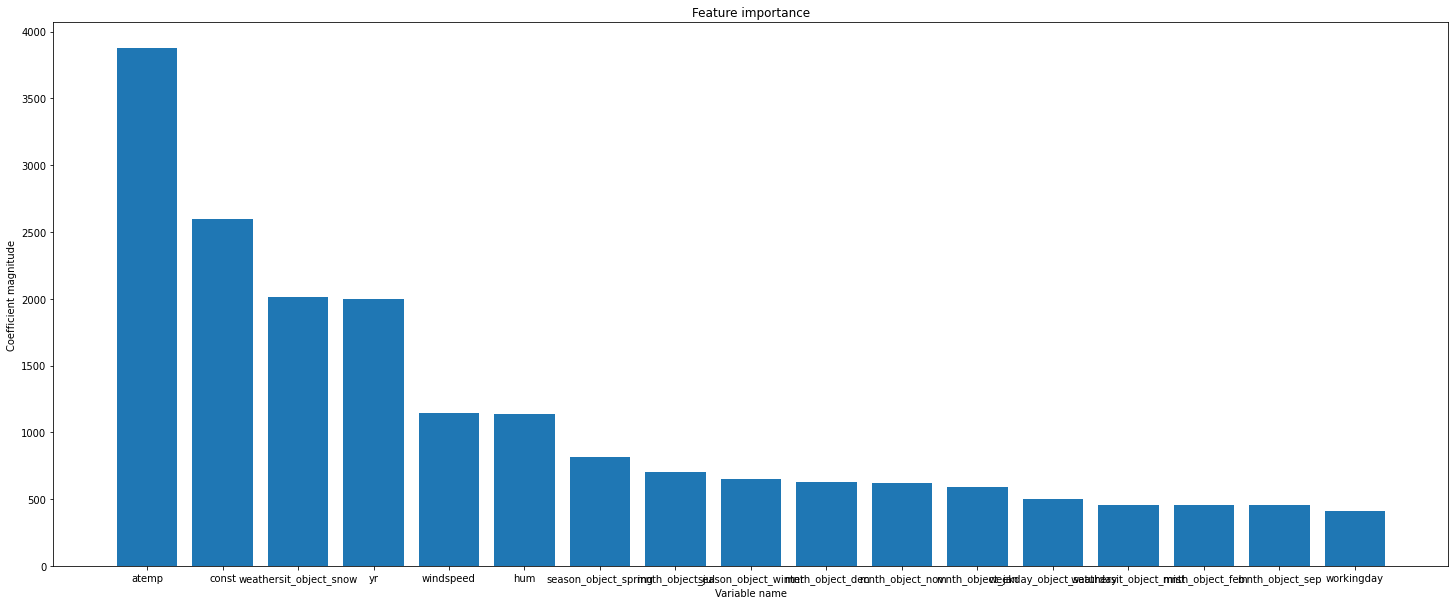

In [691]:
fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
fig, ax = plt.subplots(figsize=(25,10))
ax.bar(features['variables'],features['Coeff'])
ax.set_ylabel('Coefficient magnitude')
ax.set_xlabel('Variable name')
ax.set_title('Feature importance')

#**R-Sq value on training data: 0.84**

In [651]:
print("R-Squared:",round(r2_score(y_train, y_train_pred),2))

R-Squared: 0.84


**Adding constant column**

In [652]:
X_test_with_const = sm.add_constant(X_test)

**Predicting test values**

In [653]:
#calculating predicted values of y_train
y_test_pred = est2.predict(X_test_with_const)

#**Distribution of residuals is centered around 0 and is qualitatively normal distribution on predictions made on test data**

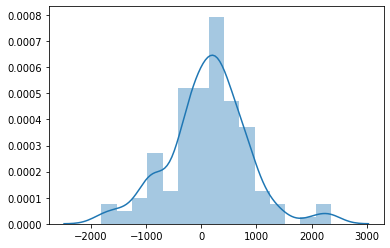

In [654]:
#plotting residuals
residuals = y_test - y_test_pred
sns.distplot(residuals)

#**R-Sq value on test data [Final OLS Model]: 0.86**
#**Adjusted R-Sq value on test data [Final OLS Model]: 0.85**

In [655]:
print("R-Squared [OLS model]:",round(r2_score(y_test, y_test_pred),2))
r2 = r2_score(y_test, y_test_pred)
adj_r2 = round((1 - (1 - r2) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1))),2)
print("Adjusted R-Squared [OLS model]:",adj_r2)

R-Squared [OLS model]: 0.86
Adjusted R-Squared [OLS model]: 0.85


#**Testing other linear regression configurations to achieve a better performing model:**

*   **Skleanr OLS**
*   **Ridge regression**
*   **Lasso regression**



**R-Sq value on test data [Sklearn linear model]: 0.86**

R-Squared [Sklearn linear model]: 0.86


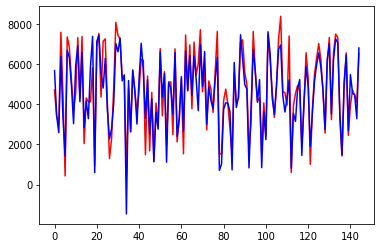

In [656]:
#linear regression model through sklearn
regression_model = LinearRegression()

#Fit the data(train the model)
regression_model.fit(X_train, y_train)

# Predict
y_predicted = regression_model.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print("R-Squared [Sklearn linear model]:",round(r2_score(y_test, y_test_pred),2))

#plotting predicted vs actual value. y_test is in dataframe format, converting it into numpy array for plotting.
plt.plot(y_test.to_numpy(), color='r')
plt.plot(y_predicted, color='b')
plt.show()

**R-Sq value on test data [Sklearn linear Ridge regression model]: 0.86**

R-Squared [Sklearn linear Ridge regression model]: 0.86


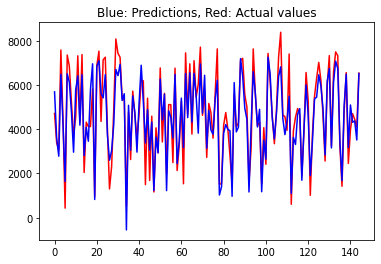

In [657]:
from sklearn import linear_model

#linear regression model through sklearn
regression_model = linear_model.Ridge(alpha=7.7)

#Fit the data(train the model)
regression_model.fit(X_train, y_train)

# Predict
y_predicted = regression_model.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print("R-Squared [Sklearn linear Ridge regression model]:",round(r2_score(y_test, y_test_pred),2))

#plotting predicted vs actual value. y_test is in dataframe format, converting it into numpy array for plotting.
plt.plot(y_test.to_numpy(), color='r')
plt.plot(y_predicted, color='b')
plt.title('Blue: Predictions, Red: Actual values')
plt.show()

**R-Sq value on test data [Sklearn linear Lasso regression model]: 0.86**

**This also means that Lasso regression is not able to eliminate any more variables than the one already removed to improve performance, thus validating our feature selection process.**

R-Squared [Sklearn linear Ridge regression model]: 0.86


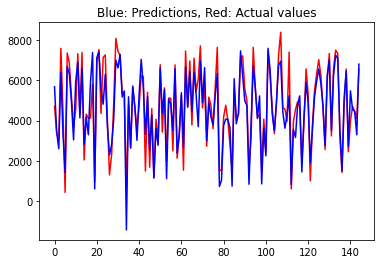

In [658]:
from sklearn import linear_model

#linear regression model through sklearn
regression_model = linear_model.Lasso(alpha=0.5)

#Fit the data(train the model)
regression_model.fit(X_train, y_train)

# Predict
y_predicted = regression_model.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print("R-Squared [Sklearn linear Ridge regression model]:",round(r2_score(y_test, y_test_pred),2))

#plotting predicted vs actual value. y_test is in dataframe format, converting it into numpy array for plotting.
plt.plot(y_test.to_numpy(), color='r')
plt.plot(y_predicted, color='b')
plt.title('Blue: Predictions, Red: Actual values')
plt.show()

#**Our final model is the OLS model with:**
*   **R-Sq = 0.86**
*   **Adjusted R-Sq = 0.85**

#**Insights for client from model results**

**Impact of climatic conditions on bike demand:**

*   Riding weather conditions have strongest impact on bike demand.
*   Bike demand increases with increasing temperature, signifying clear sunny weather.
*   Bike renting decreases with increasing humidity and windspeed (contributes to a lower temperature feel).
*   Snowfall reduces bike demand dramatically, this can be due to slippery road and bikes being more prone to accident during these weather conditions.
*   Mist reduces bike demand as well (not as much as snow), probably due to reduced visibility.

**Impact of seasonality and months on bike demand:**
*   Spring season adversely impacts bike demand, 
*   Highest number of bikes are rented in fall versus least number of bikes being rented in spring. Average temperature is lowest in spring which contributes towards lower demand. Also, probably due to melting of snow in Spring season, the road becomes slippery and accident prone.


**Impact of weekly seasonality on bike demand:**
*   More bikes are rented as weekend approaches, with highest demands on Saturday and Friday.
*   Less number of bikes are rented on Sunday, Monday.

**Impact of time/year on bike demand:**
*   Bike demand is increasing year over year strongly, indicating good revenue growth opportunities.

#**Recommendations for client**

**Countering demand suppression due to weather/climatic conditions:**
*   Offer free/rental jackets with bike when windspeed is above mean value of 12.8. This will counter the impact of wind chill, and may boost demand.
*   During snow/spring season, replace the tyres on bikes with the ones which offer highest grip on the road. Also, provide free/rental jackets to counter against windchill. This can improve confidence of customers towards biking in adverse weather. Client can probably cross-sell protective gear/jackets as well to the riders thus increasing revenues.
*   Auto-upgrade bikes with fog lights during times of the year with mist, thus improving visibility for riders on road, which can improve demand.

**Countering demand suppression due seasonality:**
For the seasons/ months /weekdays with low demand, run offers/discount to boost demand. Encourage discounted memberships, right before these low demand seasons, this will give good revenue visibility to client.

**Capitalising on increasing demand year over year:**
Do demographic/behavioral targeting of people likely to adopt biking and reach out to this new customer pool through targeted marketing campaigns. Encourage free trial for these new customer set. Also, maintain a healthy inventory of bikes in line with demand prediction.



